# Price Prediction by Nueral Network

## Dataset

Four years, 3/1/2015 to 3/1/2019, dairy based price data of EUR/USD

## Topics

- Create a model of 1 dimensional CNN and make it predict the future prices
- Execute a trading simulation by following model prediction

In [256]:
import keras
from keras.models import Sequential
from keras.layers import (
    Dense, Conv1D, MaxPooling1D, CuDNNLSTM, Dropout, Activation
)
from keras.optimizers import Adam
from keras.layers.core import Flatten

import numpy as np
import pandas as pd

from oandaapi import get_exrate_as_df

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = get_exrate_as_df(instrument='EUR_USD', from_='2015-03-01', to='2019-03-01')

In [3]:
print(len(df))
df.tail()

1040


,open,high,low,close,volume
time,,,,,
2019-02-24 22:00:00,1.13359,1.13675,1.13286,1.13574,13830.0
2019-02-25 22:00:00,1.13616,1.14028,1.13453,1.13892,17286.0
2019-02-26 22:00:00,1.13894,1.14036,1.13624,1.13695,16900.0
2019-02-27 22:00:00,1.13673,1.14197,1.13596,1.13706,20344.0
2019-02-28 22:00:00,1.13706,1.14086,1.13532,1.13648,17278.0


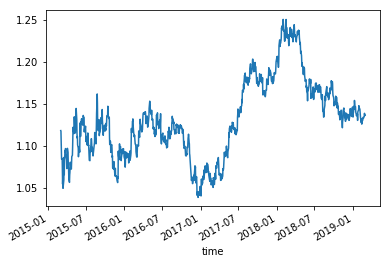

In [15]:
df['close'].plot()
plt.show()

In [230]:
mean = df['close'].mean()
std = df['close'].std()

In [231]:
normed_data = np.array((df['close'] - mean) / std)
normed_data

array([-0.28581342, -0.30120335, -0.50918126, ...,  0.11154622,
        0.11389746,  0.10150001])

In [234]:
def create_train_test_data(data, span, slide, train_rate):
    train_size = int(train_rate*len(data))
    
    X, y = [], []
    for i in range(span, len(data)-1, slide):
        X.append(data[i-span:i])
        y.append(data[i+1])
    X = np.array(X).reshape((-1, span, 1))
    y = np.array(y).reshape((-1, 1))
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    return X_train, y_train, X_test, y_test

Separate the dataset and make train data and test data.
The ratio of train and test is 6:4.

In [248]:
X_train, y_train, X_test, y_test =    \
    create_train_test_data(normed_data, span=20, slide=1, train_rate=0.6)

## CNN Model Construction

In [249]:
input_shape = (LEARNING_SPAN, 1)

model = Sequential()
model.add(Conv1D(
    32, 3, activation='relu', padding='valid',
    input_shape=input_shape
))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,
                 3,
                 activation='relu',
                 padding='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

## Learning

The batch and epoch size are determined as 200 and 50 respectively.

In [250]:
epoch = 50
batch_size = 200
history = model.fit(X_train, y_train, epochs=epoch,
                      batch_size=batch_size,
                      validation_data=(X_test, y_test))

Train on 624 samples, validate on 395 samples
Epoch 1/50
624/624 [==============================] - 2s 3ms/step - loss: 0.6049 - acc: 0.0000e+00 - val_loss: 1.2559 - val_acc: 0.0000e+00
Epoch 2/50
624/624 [==============================] - 0s 83us/step - loss: 0.2074 - acc: 0.0000e+00 - val_loss: 0.8093 - val_acc: 0.0000e+00
Epoch 3/50
624/624 [==============================] - 0s 125us/step - loss: 0.2200 - acc: 0.0000e+00 - val_loss: 0.2921 - val_acc: 0.0000e+00
Epoch 4/50
624/624 [==============================] - 0s 138us/step - loss: 0.1656 - acc: 0.0000e+00 - val_loss: 0.0871 - val_acc: 0.0000e+00
Epoch 5/50
624/624 [==============================] - 0s 121us/step - loss: 0.1588 - acc: 0.0000e+00 - val_loss: 0.1183 - val_acc: 0.0000e+00
Epoch 6/50
624/624 [==============================] - 0s 123us/step - loss: 0.1596 - acc: 0.0000e+00 - val_loss: 0.2072 - val_acc: 0.0000e+00
Epoch 7/50
624/624 [==============================] - 0s 122us/step - loss: 0.1384 - acc: 0.0000e+00 - va

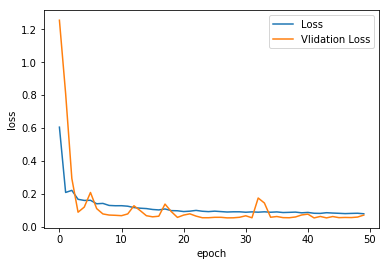

In [251]:
plt.plot(range(epoch), history.history['loss'], label='Loss')
plt.plot(range(epoch), history.history['val_loss'], label='Vlidation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

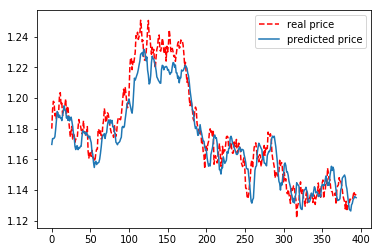

In [252]:
prediction = model.predict(X_test)
plt.plot( y_test * std+mean ,label='real price', color='r', linestyle='--')
plt.plot(prediction * std +mean, label='predicted price' )
plt.legend()
plt.show()

In [253]:
def take_position_by_prediction(open_price, real_price, predicted_price):
    if predicted_price > open_price:    # Take Long Position
        return real_price - open_price
    else:                                                   # Take Short Position
        return open_price - real_price

def trade_simulation(start_price, model, X_test, y_test, mean, std):
    earnings = np.zeros(len(y_test))
    span = len(X_test[0])
    for i in range(len(y_test)):
        open_price = start_price if i == 0 else y_test[i-1][0]*std + mean
        real_price = y_test[i][0]*std + mean
        y = model.predict(X_test[i].reshape(1, span, -1))[0][0]
        predicted_price = y*std + mean
        one_day_earning = take_position_by_prediction(open_price, real_price, predicted_price)
        earnings[i] = one_day_earning if i == 0 else one_day_earning + earnings[i-1]
    return earnings

In [254]:
start_price = y_train[-1][0]
earnings = trade_simulation(start_price, model, X_test, y_test, mean, std)

Max: 21.69 % Min: 9.64 %


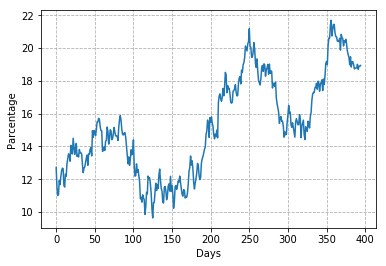

In [255]:
earnings_pct = earnings*100/start_price
print('Max: {0:.2f} %'.format(earnings_pct.max()) , 'Min: {0:.2f} %'.format(earnings_pct.min()))
plt.plot(earnings*100/start_price)
plt.xlabel('Days')
plt.ylabel('Expected Return Parcentage')
plt.grid(linestyle='--')
plt.show()